# Referent > Utterance Mapping
_This notebook creates a mapping of utterances to referents, using sounds from the FSD50K dataset as the referent space._

In [1]:
import numpy as np
import os
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import itertools
import math
from tqdm import tqdm
import csv
import pickle
import random
import time

from IPython.display import Audio, display
import matplotlib.pyplot as plt

from RSA_helpers import *

In [2]:
device = ("mps" if torch.backends.mps.is_available() else "cpu")
print("using device:", device)
torch.set_default_dtype(torch.float)

using device: mps


## Data processing

In [3]:
# list of all referents
all_referents = [d for d in os.listdir(REFERENT_DATA_DIR) if (os.path.isfile(os.path.join(REFERENT_DATA_DIR, d)) and d[-4:]=='.wav')]

random.seed(10)
referent_random_subset = all_referents[:]
random.shuffle(referent_random_subset)
referent_random_subset = referent_random_subset[:3000]

In [4]:
# choose which set we wanna use
# referents = all_referents
referents = referent_random_subset
N_REFERENTS = len(referents)
print("total referents:", N_REFERENTS)

total referents: 3000


## Audio features

In [5]:
feature_extractor = SimpleAudioFeatures()

## Preprocess

### Referent features

In [6]:
# found this by testing codeboxes below manually, should be computable..
FEAT_LEN = 44

In [7]:
def extract_all_referent_features():
    resampler = T.Resample(20_000, AUDIO_SR)
    S_features = torch.zeros((len(referents),) + (FEAT_LEN*N_AUDIO_FEATURES,))
    NOISE_EPS = 1e-15
    
    for i, sample in tqdm(enumerate(referents), total=len(referents)):
        sample_audio, sr = torchaudio.load(REFERENT_DATA_DIR + sample)
        sample_audio = sample_audio.repeat((1,5))      # COPY TO BE >= REF - FOR ONESHOTS
        resampled = resampler(sample_audio[0,:])[:AUDIO_SR*SAMPLE_LEN//CONTROL_SR]

        # add tiny noise since zeros give log NaNs for derivatives
        noised = resampled + torch.randn(AUDIO_SR*SAMPLE_LEN//CONTROL_SR)*NOISE_EPS
        features = feature_extractor(noised)
        feature_vector = torch.reshape(features, (-1,))
        S_features[i,:] = feature_vector
    
    S_features = torch.nn.functional.normalize(S_features, dim=-1)
    torch.save(S_features, '../data/FSD50/eval_audio_features.pt')


extract_all_referent_features()

S_features = torch.load('../data/FSD50/eval_audio_features.pt', weights_only=True)

100%|███████████████████████████████████████| 3000/3000 [00:54<00:00, 54.60it/s]


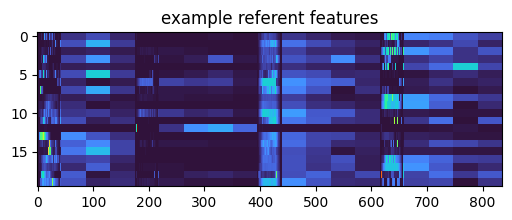

In [8]:
plt.figure(figsize=(6,2))
plt.imshow(S_features[200:220, :], interpolation='nearest', aspect='auto', cmap='turbo')
plt.title("example referent features")
plt.show()

### Utterance features

In [10]:
# test one
U_features = torch.zeros((N_GRID_SEQ_TYPE,)*N_VOCAL_TRACT_CONTROLS + (FEAT_LEN*N_AUDIO_FEATURES,))

# extract features for a random one
controls_tup = (4,7,6,4,8)
U_audio, sr = torchaudio.load(VOCAL_DATA_DIR + f'{'-'.join(map(str,controls_tup))}.wav')
features = feature_extractor(U_audio[0,:])
U_features[*controls_tup] = features

LibsndfileError: Error opening '../data/vocal_synth_f/4-7-6-4-8.wav': System error.

### Run feature extraction (& save)

In [78]:
def extract_all_utterace_features():
    U_features = torch.zeros((N_GRID_SEQ_TYPE,)*N_VOCAL_TRACT_CONTROLS + (FEAT_LEN*N_AUDIO_FEATURES,))
    feature_extractor = SimpleAudioFeatures()

    # populate utterance feature tensor; assuming referent filenames of type 3-1-5-3-4.wav
    for controls_tup in tqdm(itertools.product(range(0, N_SEQ_TYPES), repeat=N_VOCAL_TRACT_CONTROLS), total=N_SEQ_TYPES**N_VOCAL_TRACT_CONTROLS):
        U_audio, sr = torchaudio.load(VOCAL_DATA_DIR + f'{'-'.join(map(str,controls_tup))}.wav')
        features = feature_extractor(U_audio[0,:])
        U_features[*controls_tup] = features
    
    torch.save(U_features, '../data/vocal_synth/U_features_raw.pt')

# extract all (TAKES A LONG TIME)
# extract_all_utterace_features()

### Fetch, normalize, plot to verify

In [12]:
# fetch & normalize
U_features = torch.load('../data/U_features_raw.pt', weights_only=True)
U_features = torch.nn.functional.normalize(U_features, dim=-1)

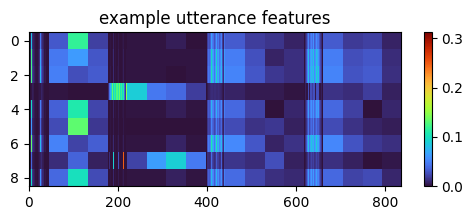

In [13]:
# plot a few
plt.figure(figsize=(6,2))
plt.imshow(U_features[8,4,6,:9,7], interpolation='nearest', aspect='auto', cmap='turbo')
plt.colorbar()
plt.title('example utterance features')
plt.show()

## Utterance costs

In [14]:
# copied from SF_data_gen
def lookup_grid_seq(seq_order, length):
    # constant
    if seq_order <= 3:
        return 0.33*seq_order*torch.ones(SAMPLE_LEN)
    # sine
    elif seq_order <= 6:
        return 0.5 + 0.4*torch.sin(torch.linspace(0,SAMPLE_LEN//CONTROL_SR,steps=SAMPLE_LEN)*2*math.pi*(seq_order-3))
    # sine biased hi
    elif seq_order <= 7:
        return 0.75 + 0.25*torch.sin(torch.linspace(0,SAMPLE_LEN//CONTROL_SR,steps=SAMPLE_LEN)*2*math.pi*(seq_order-5))
    # sine biased low
    elif seq_order <= 8:
        return 0.25 + 0.25*torch.sin(torch.linspace(0,SAMPLE_LEN//CONTROL_SR,steps=SAMPLE_LEN)*2*math.pi*(seq_order-6))
    # falling saw
    elif seq_order <= 9:
        return 1 - (torch.linspace(0, SAMPLE_LEN*(seq_order-7), steps=SAMPLE_LEN) % 1)
    # random
    else:
        return torch.rand(SAMPLE_LEN//3 + 3).repeat_interleave(3)[:SAMPLE_LEN]


# calculate derivative & squared dist from 0.5 for each sequence
seq_costs = []

for i in range(N_GRID_SEQ_TYPE):
    seq = lookup_grid_seq(i, CONTROL_SR*2)
    deriv = abs(seq - seq.roll(1))
    dist = (seq - 0.5)**2  * 0.7
    seq_costs.append(torch.sum(deriv) + torch.sum(dist))

In [15]:
U_costs = torch.zeros((N_GRID_SEQ_TYPE,)*N_VOCAL_TRACT_CONTROLS)

# populate cost tensor
for controls_tup in itertools.product(range(0, N_GRID_SEQ_TYPE), repeat=N_VOCAL_TRACT_CONTROLS):
    cost = torch.sum(torch.tensor([seq_costs[seq_type] for seq_type in controls_tup]))
    U_costs[*controls_tup] = cost

# normalize to [0, 1]
U_costs /= torch.max(U_costs)

## Ontological distance (utility)

In [16]:
# build ontology datastructure
tree = build_ontology_tree()

In [17]:
sounds = [
    ('shout', '/m/07p6fty'),
    ('whispering', '/m/02rtxlg'),
    ('crowd', '/m/03qtwd'),
    ('car passing by', '/t/dd00134'),
]

# print("path to shout:", find_key(tree, sounds[2][1]), "\n")
for i in range(len(sounds)):
    for j in range(i, len(sounds)):
        dist = get_ontology_dist(tree, sounds[i][0], sounds[j][0])
        print(f"{sounds[i][0]} <> {sounds[j][0]}:", dist)

shout <> shout: 0
shout <> whispering: 2
shout <> crowd: 4
shout <> car passing by: 8
whispering <> whispering: 0
whispering <> crowd: 4
whispering <> car passing by: 8
crowd <> crowd: 0
crowd <> car passing by: 8
car passing by <> car passing by: 0


In [18]:
REF_TO_CAT_PATH = '../data/pickles/FSD50k_categories.pickle'

def find_all_referent_categories():
    referent_to_category = {}

    # find categories
    with open(REFERENT_METADATA_PATH, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader, None)  # skip header
        for row in tqdm(reader, total=10231):
            category_paths = [(find_key(tree, cat), cat) for cat in row[1].split(',')]
            most_specific_category = max(category_paths)[1]
            referent_to_category[row[0]] = most_specific_category

    # save to file
    with open(REF_TO_CAT_PATH, 'wb') as handle:
        pickle.dump(referent_to_category, handle, protocol=pickle.HIGHEST_PROTOCOL)


# find_all_referent_categories()

with open(REF_TO_CAT_PATH, 'rb') as handle:
    referent_to_category = pickle.load(handle)

In [24]:
# for each referent, find ontological distance to other referents - upper triangular matrix

def calculate_all_cross_referent_distances():
    # DP cache - this is horrifically inefficient otherwise
    known_dict = {}
    referent_dists = torch.zeros((N_REFERENTS, N_REFERENTS))
    for i, j in tqdm(itertools.combinations(range(N_REFERENTS), 2), total = N_REFERENTS**2/2):
        categoryA = referent_to_category[referents[i].split('.')[0]]
        categoryB = referent_to_category[referents[j].split('.')[0]]
        if (categoryA, categoryA) in known_dict:
            referent_dists[i][j] = known_dict[(categoryA, categoryA)]
        else:
            dist = get_ontology_dist(tree, categoryA, categoryB)
            referent_dists[i][j] = dist
            known_dict[(categoryA, categoryA)] = dist
    torch.save(referent_dists, '../data/FSD50/cross_category_distances.pt')


calculate_all_cross_referent_distances()
cross_ref_dists = torch.load('../data/FSD50/cross_category_distances.pt', weights_only=True)

# upper triangular to symmetric
cross_ref_dists = torch.where(cross_ref_dists != 0, cross_ref_dists, cross_ref_dists.T)

100%|████████████████████████████████████████████▉| 4498500/4500000.0 [00:16<00:00, 264965.09it/s]


## RSA

In [25]:
# for speed
U_features.to(device)
S_features.to(device)
cross_ref_dists.to(device)
U_costs.to(device)

# for convenience
NTN = torch.nan_to_num

In [26]:
# meaning matrix
meaning = torch.mm(torch.reshape(U_features, (N_GRID_SEQ_TYPE**N_VOCAL_TRACT_CONTROLS, FEAT_LEN*N_AUDIO_FEATURES)), S_features.T)
meaning = NTN(meaning)

assert list(meaning.shape) == [N_GRID_SEQ_TYPE**N_VOCAL_TRACT_CONTROLS, N_REFERENTS], \
       "incorrect meaning matrix shape dimension; this probably means we need to recompute referent features for this domain" 

print(f"total utterance-referent pairs: {meaning.shape[0]*meaning.shape[1]:,}")

total utterance-referent pairs: 483,153,000


In [27]:
ONT_DIST_PENALTY = 0.8   # higher penalty = sharper falloff w/ distance

cross_ref_dists = torch.exp(-ONT_DIST_PENALTY*cross_ref_dists)

meaning: (utterances, referents)

cross_ref_dists: (referents, referents)

### Literal listener + Utility

In [28]:
COST_FACTOR = 0.2

def calculate_utility():
    literal_listener = NTN(meaning / torch.sum(meaning, 0, keepdim=True))
    
    utility = torch.zeros_like(literal_listener)
    for i in tqdm(range(N_REFERENTS)):
        distances_to_referent = cross_ref_dists[:,i].unsqueeze(0)  
        distances_to_referent = distances_to_referent.repeat((N_GRID_SEQ_TYPE**N_VOCAL_TRACT_CONTROLS, 1))  # copy for all utterances
        referent_dist_likelihood = distances_to_referent*literal_listener   # elem (ref, ut) = ref to referent i * prob that ut selects ref
        utility[:,i] = referent_dist_likelihood.sum(dim=1)    # sum total distance

    torch.save(utility, '../data/FSD50/utility.pt')

calculate_utility()

meaning = torch.load('../data/FSD50/utility.pt', weights_only=True)

  3%|█▌                                                       | 85/3000 [03:34<2:02:19,  2.52s/it]


KeyboardInterrupt: 

In [91]:
pragmatic_speaker = NTN(meaning / torch.sum(meaning, 1, keepdim=True))
# pragmatic_listener = NTN(pragmatic_speaker / torch.sum(pragmatic_speaker, 0, keepdim=True))

In [92]:
utilities = torch.reshape(pragmatic_speaker, (N_GRID_SEQ_TYPE,)*N_VOCAL_TRACT_CONTROLS + (len(referents),))

for i, sample in enumerate(referents[1:2]):
    probs = utilities[:,:,:,:,:,i]
    best = torch.argmax(probs)
    best_ID = '-'.join(map(str, [x.item() for x in torch.unravel_index(best, probs.shape)]))
    print('\nReferent:', referent_to_category[sample.split('.')[0]], ',  Utterance:', best_ID)

    samples, sr = torchaudio.load(VOCAL_DATA_DIR + best_ID + '.wav')
    audioelem = Audio(samples[0,:], rate=sr)
    display(audioelem)
    samples, sr = torchaudio.load(REFERENT_DATA_DIR + sample)
    audioelem = Audio(samples[0,:], rate=sr)
    display(audioelem)


Referent: Bowed_string_instrument ,  Utterance: 8-0-4-8-4


In [93]:
def save_ref_ut_mapping():
    utilities = torch.reshape(pragmatic_speaker, (N_GRID_SEQ_TYPE,)*N_VOCAL_TRACT_CONTROLS + (len(referents),))
    
    mapping = []
    for i, sample in tqdm(enumerate(referents)):
        probs = utilities[:,:,:,:,:,i]
        best = torch.argmax(probs)
        best_ID = '-'.join(map(str, [x.item() for x in torch.unravel_index(best, probs.shape)]))
        mapping.append([referent_to_category[sample.split('.')[0]], best_ID])

    np.save("../data/pickles/ref_ut_mapping.npy", np.array(mapping))

save_ref_ut_mapping()

3000it [00:03, 961.03it/s] 


## Naive match (for comparison)

In [94]:
for i, sample in enumerate(referents):
    meaning = torch.sum(U_features * feature_vector, -1)
    U_best = torch.argmax(meaning)
    best_ID = ''.join(map(str, [x.item() for x in torch.unravel_index(U_best, meaning.shape)]))
    print('best utterance for', sample, 'is', best_ID)

sample, sr = torchaudio.load(VOCAL_DATA_DIR + '01145.wav')
Audio(sample[0,:], rate=sr)

NameError: name 'feature_vector' is not defined